In [ ]:
#!/usr/bin/env python3
"""
Visualization Tools for Customer Support Sentiment Analysis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# For Jupyter notebooks
from IPython.display import display, HTML

# Cell 1: Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, 
                         title='Confusion Matrix', figsize=(8, 6), cmap='Blues'):
    """
    Create a beautiful confusion matrix visualization
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
    else:
        fmt = 'd'
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names or ['Class 0', 'Class 1'],
                yticklabels=class_names or ['Class 0', 'Class 1'],
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    
    # Add metrics
    accuracy = np.trace(cm) / np.sum(cm)
    plt.text(0.5, -0.12, f'Accuracy: {accuracy:.2%}', 
             transform=plt.gca().transAxes, ha='center', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return cm

# Cell 2: ROC Curve Visualization
def plot_roc_curve(y_true, y_proba, class_names=None, title='ROC Curves', 
                   figsize=(10, 8)):
    """
    Plot ROC curves for binary or multi-class classification
    """
    plt.figure(figsize=figsize)
    
    # Binary classification
    if y_proba.shape[1] == 2:
        fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})', color='darkorange')
        
        # Add confidence interval
        plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
        
    else:
        # Multi-class
        n_classes = y_proba.shape[1]
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        
        colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
        
        for i, color in enumerate(colors):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            class_label = class_names[i] if class_names else f'Class {i}'
            
            plt.plot(fpr, tpr, linewidth=2, color=color,
                    label=f'{class_label} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
    
    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    
    # Add diagonal fill
    plt.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')
    
    plt.tight_layout()
    plt.show()

# Cell 3: Model Comparison Visualization
def plot_model_comparison(results_dict, metrics=['Accuracy', 'Precision', 'Recall', 'F1-Score'], 
                         title='Model Performance Comparison', figsize=(12, 8)):
    """
    Create comprehensive model comparison visualization
    """
    # Convert to DataFrame if dict
    if isinstance(results_dict, dict):
        data = []
        for model, scores in results_dict.items():
            row = {'Model': model}
            row.update(scores)
            data.append(row)
        df = pd.DataFrame(data)
    else:
        df = results_dict
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 1. Grouped bar chart
    x = np.arange(len(df))
    width = 0.2
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
    
    for i, metric in enumerate(metrics):
        if metric in df.columns:
            ax1.bar(x + i*width, df[metric], width, label=metric, 
                   color=colors[i % len(colors)], alpha=0.8)
    
    ax1.set_xlabel('Models', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Model Comparison - Bar Chart', fontsize=14)
    ax1.set_xticks(x + width * (len(metrics)-1) / 2)
    ax1.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # Add value labels
    for i, metric in enumerate(metrics):
        if metric in df.columns:
            for j, (idx, row) in enumerate(df.iterrows()):
                ax1.text(j + i*width, row[metric] + 0.01, f'{row[metric]:.3f}', 
                        ha='center', va='bottom', fontsize=9)
    
    # 2. Radar chart
    categories = [m for m in metrics if m in df.columns]
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax2 = plt.subplot(122, projection='polar')
    
    for idx, row in df.iterrows():
        values = [row[cat] for cat in categories]
        values += values[:1]
        
        ax2.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
        ax2.fill(angles, values, alpha=0.15)
    
    ax2.set_theta_offset(np.pi / 2)
    ax2.set_theta_direction(-1)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(categories)
    ax2.set_ylim(0, 1)
    ax2.set_title('Model Comparison - Radar Chart', fontsize=14, pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax2.grid(True)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Cell 4: Feature Importance Visualization
def plot_feature_importance(feature_names, importance_scores, top_n=20, 
                           title='Feature Importance', figsize=(10, 8)):
    """
    Visualize feature importance with horizontal bar chart
    """
    # Sort and select top features
    indices = np.argsort(np.abs(importance_scores))[-top_n:]
    top_features = [feature_names[i] for i in indices]
    top_scores = importance_scores[indices]
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Color based on positive/negative
    colors = ['green' if score > 0 else 'red' for score in top_scores]
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(top_features)), top_scores, 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, top_scores)):
        plt.text(score + np.sign(score) * 0.001, i, f'{score:.3f}', 
                va='center', ha='left' if score > 0 else 'right', fontsize=10)
    
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.grid(True, axis='x', alpha=0.3)
    
    # Add zero line
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    plt.tight_layout()
    plt.show()

# Cell 5: Word Cloud Visualization
def create_word_cloud(texts, title='Word Cloud', figsize=(12, 8), 
                      colormap='viridis', background_color='white'):
    """
    Create beautiful word cloud from texts
    """
    # Combine all texts
    if isinstance(texts, pd.Series):
        combined_text = ' '.join(texts.astype(str))
    else:
        combined_text = ' '.join([str(text) for text in texts])
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color=background_color,
                         colormap=colormap,
                         max_words=100,
                         relative_scaling=0.5,
                         random_state=42).generate(combined_text)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Cell 6: Training History Visualization
def plot_training_history(history, metrics=['loss', 'accuracy'], 
                         title='Training History', figsize=(12, 5)):
    """
    Plot training history for neural networks
    """
    if isinstance(history, dict):
        history_dict = history
    else:
        history_dict = history.history
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    if len(metrics) == 1:
        axes = [axes]
    
    for ax, metric in zip(axes, metrics):
        # Plot training metric
        if metric in history_dict:
            ax.plot(history_dict[metric], label=f'Training {metric.capitalize()}', 
                   linewidth=2, marker='o', markersize=4)
        
        # Plot validation metric if available
        val_metric = f'val_{metric}'
        if val_metric in history_dict:
            ax.plot(history_dict[val_metric], label=f'Validation {metric.capitalize()}', 
                   linewidth=2, marker='s', markersize=4, linestyle='--')
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_title(f'{metric.capitalize()} Over Time', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add best value marker
        if val_metric in history_dict:
            if 'loss' in metric:
                best_epoch = np.argmin(history_dict[val_metric])
            else:
                best_epoch = np.argmax(history_dict[val_metric])
            best_value = history_dict[val_metric][best_epoch]
            ax.scatter(best_epoch, best_value, color='red', s=100, zorder=5)
            ax.annotate(f'Best: {best_value:.4f}', 
                       xy=(best_epoch, best_value), 
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Cell 7: Class Distribution Visualization
def plot_class_distribution(y, class_names=None, title='Class Distribution', 
                           figsize=(10, 6)):
    """
    Visualize class distribution with bar and pie charts
    """
    unique_classes, counts = np.unique(y, return_counts=True)
    
    if class_names is None:
        class_names = [f'Class {i}' for i in unique_classes]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Bar chart
    colors = sns.color_palette("husl", len(counts))
    bars = ax1.bar(class_names, counts, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({count/sum(counts)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Class Distribution - Bar Chart', fontsize=14)
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Pie chart
    explode = [0.05] * len(counts)  # Slightly explode all slices
    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', 
           colors=colors, explode=explode, shadow=True, startangle=90)
    ax2.set_title('Class Distribution - Pie Chart', fontsize=14)
    
    # Add total samples info
    fig.text(0.5, 0.02, f'Total Samples: {sum(counts):,}', 
             ha='center', fontsize=12, weight='bold')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Cell 8: Error Analysis Visualization
def plot_error_analysis(y_true, y_pred, X_test=None, class_names=None, 
                       title='Error Analysis', figsize=(12, 8)):
    """
    Visualize prediction errors
    """
    # Find misclassified indices
    misclassified = y_true != y_pred
    misclassified_idx = np.where(misclassified)[0]
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # 1. Error rate by class
    ax1 = plt.subplot(2, 2, 1)
    unique_classes = np.unique(y_true)
    error_rates = []
    
    for cls in unique_classes:
        mask = y_true == cls
        error_rate = np.mean(y_pred[mask] != y_true[mask])
        error_rates.append(error_rate)
    
    class_labels = class_names if class_names else [f'Class {i}' for i in unique_classes]
    bars = ax1.bar(class_labels, error_rates, color='salmon', alpha=0.7)
    
    # Add value labels
    for bar, rate in zip(bars, error_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom')
    
    ax1.set_ylabel('Error Rate')
    ax1.set_title('Error Rate by Class')
    ax1.grid(True, axis='y', alpha=0.3)
    
    # 2. Confusion patterns
    ax2 = plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot only errors (set diagonal to 0)
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)
    
    sns.heatmap(cm_errors, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
    ax2.set_title('Misclassification Patterns')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    # 3. Error distribution
    ax3 = plt.subplot(2, 1, 2)
    error_counts = pd.Series(y_true[misclassified]).value_counts()
    ax3.pie(error_counts.values, labels=[class_labels[i] for i in error_counts.index],
            autopct='%1.1f%%', colors=sns.color_palette("husl", len(error_counts)))
    ax3.set_title('Distribution of Misclassified Samples')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Total Errors: {len(misclassified_idx)} out of {len(y_true)} ({len(misclassified_idx)/len(y_true)*100:.1f}%)")

# Cell 9: Interactive Plotly Visualizations
def create_interactive_model_comparison(results_df, title='Interactive Model Comparison'):
    """
    Create interactive model comparison using Plotly
    """
    # Melt dataframe for better plotting
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    df_melted = results_df.melt(id_vars=['Model'], value_vars=metrics,
                               var_name='Metric', value_name='Score')
    
    # Create grouped bar chart
    fig = px.bar(df_melted, x='Model', y='Score', color='Metric',
                barmode='group', title=title,
                labels={'Score': 'Performance Score'},
                hover_data={'Score': ':.3f'})
    
    fig.update_layout(
        xaxis_tickangle=-45,
        height=600,
        showlegend=True,
        yaxis_range=[0, 1.1]
    )
    
    # Add horizontal line at 0.8
    fig.add_hline(y=0.8, line_dash="dash", line_color="gray",
                 annotation_text="Good Performance Threshold")
    
    fig.show()

# Cell 10: Sentiment Analysis Results Visualization
def plot_sentiment_results(predictions, probabilities, texts=None, 
                          title='Sentiment Analysis Results', figsize=(15, 10)):
    """
    Comprehensive visualization of sentiment analysis results
    """
    fig = plt.figure(figsize=figsize)
    
    # 1. Prediction distribution
    ax1 = plt.subplot(2, 3, 1)
    unique, counts = np.unique(predictions, return_counts=True)
    colors = ['red' if p == 0 else 'green' for p in unique]
    bars = ax1.bar(['Negative', 'Positive'], counts, color=colors, alpha=0.7)
    
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{count}', ha='center', va='bottom')
    
    ax1.set_title('Prediction Distribution')
    ax1.set_ylabel('Count')
    
    # 2. Confidence distribution
    ax2 = plt.subplot(2, 3, 2)
    confidences = np.max(probabilities, axis=1)
    ax2.hist(confidences, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(confidences.mean(), color='red', linestyle='--', 
               label=f'Mean: {confidences.mean():.3f}')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Confidence Distribution')
    ax2.legend()
    
    # 3. Confidence by prediction
    ax3 = plt.subplot(2, 3, 3)
    neg_conf = confidences[predictions == 0]
    pos_conf = confidences[predictions == 1]
    
    ax3.boxplot([neg_conf, pos_conf], labels=['Negative', 'Positive'])
    ax3.set_ylabel('Confidence Score')
    ax3.set_title('Confidence by Sentiment')
    
    # 4. Low confidence samples
    ax4 = plt.subplot(2, 3, 4)
    low_conf_threshold = 0.6
    low_conf_mask = confidences < low_conf_threshold
    low_conf_preds = predictions[low_conf_mask]
    
    if len(low_conf_preds) > 0:
        unique_low, counts_low = np.unique(low_conf_preds, return_counts=True)
        labels = ['Negative' if p == 0 else 'Positive' for p in unique_low]
        # Adjust colors based on actual classes present
        pie_colors = []
        for p in unique_low:
            pie_colors.append('red' if p == 0 else 'green')
        ax4.pie(counts_low, labels=labels, autopct='%1.1f%%', 
               colors=pie_colors)
        ax4.set_title(f'Low Confidence (<{low_conf_threshold}) Predictions')
    else:
        ax4.text(0.5, 0.5, 'No low confidence predictions', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Low Confidence Predictions')
    
    # 5. Probability distribution
    ax5 = plt.subplot(2, 3, 5)
    pos_probs = probabilities[:, 1]
    ax5.hist(pos_probs, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax5.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
    ax5.set_xlabel('Positive Class Probability')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Probability Distribution')
    ax5.legend()
    
    # 6. Summary stats
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_text = f"""
    Summary Statistics:
    
    Total Predictions: {len(predictions):,}
    Positive: {np.sum(predictions == 1):,} ({np.mean(predictions == 1)*100:.1f}%)
    Negative: {np.sum(predictions == 0):,} ({np.mean(predictions == 0)*100:.1f}%)
    
    Average Confidence: {confidences.mean():.3f}
    Min Confidence: {confidences.min():.3f}
    Max Confidence: {confidences.max():.3f}
    
    Low Confidence (<{low_conf_threshold}): {np.sum(low_conf_mask)} ({np.mean(low_conf_mask)*100:.1f}%)
    High Confidence (>0.9): {np.sum(confidences > 0.9)} ({np.mean(confidences > 0.9)*100:.1f}%)
    """
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
            fontsize=11, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage in Jupyter
if __name__ == "__main__":
    print("Visualization functions loaded successfully!")
    print("\nAvailable functions:")
    print("- plot_confusion_matrix()")
    print("- plot_roc_curve()")
    print("- plot_model_comparison()")
    print("- plot_feature_importance()")
    print("- create_word_cloud()")
    print("- plot_training_history()")
    print("- plot_class_distribution()")
    print("- plot_error_analysis()")
    print("- create_interactive_model_comparison()")
    print("- plot_sentiment_results()")

Visualization functions loaded successfully!

Available functions:
- plot_confusion_matrix()
- plot_roc_curve()
- plot_model_comparison()
- plot_feature_importance()
- create_word_cloud()
- plot_training_history()
- plot_class_distribution()
- plot_error_analysis()
- create_interactive_model_comparison()
- plot_sentiment_results()


In [ ]:
# Cell 1: Load your processed data and train a model first
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Load processed data
amazon_df = pd.read_csv('processed_data/amazon_processed.csv')
print(f"Loaded {len(amazon_df)} reviews")

# Prepare data
X = amazon_df['processed_text'].fillna('').values
y = amazon_df['binary_sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

# Train a simple model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Training model...")
pipeline.fit(X_train, y_train)

# Get predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(" Now you have y_test, y_pred, and y_proba ready for visualization!")

Loaded 10000 reviews
Training set: 8000
Test set: 2000
Training model...
Accuracy: 0.8640
✅ Now you have y_test, y_pred, and y_proba ready for visualization!


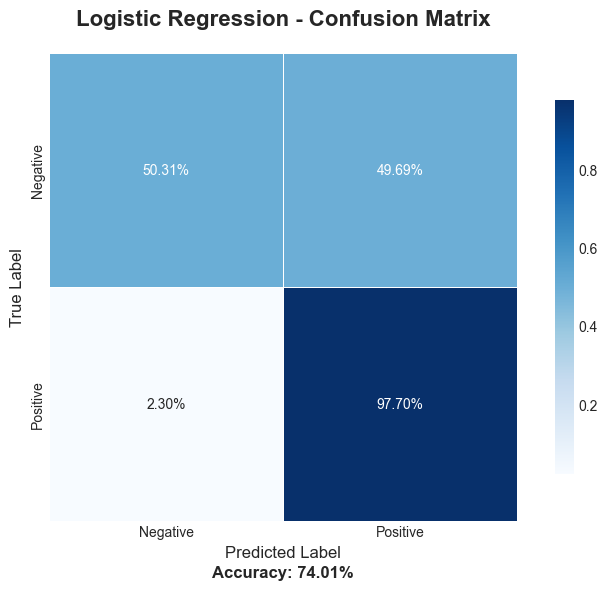

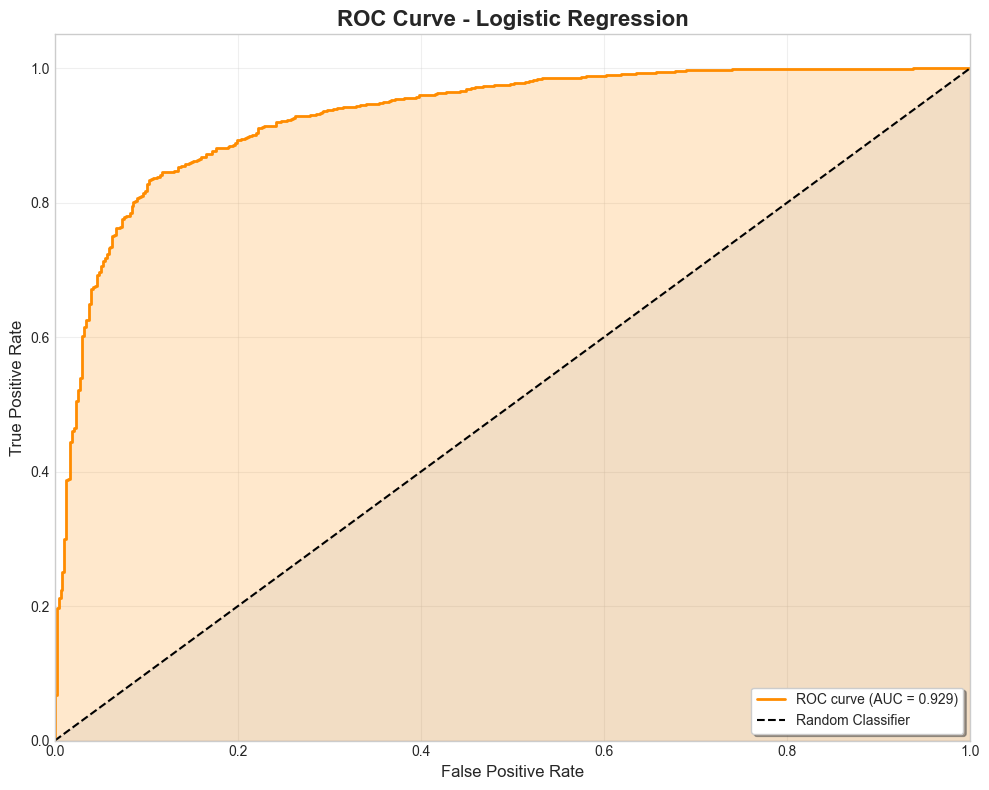

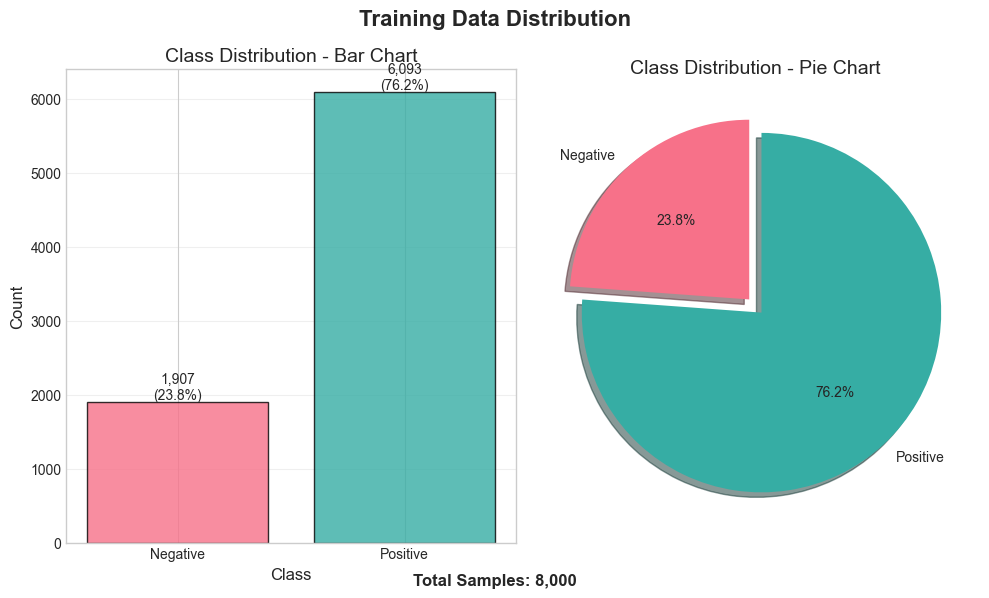

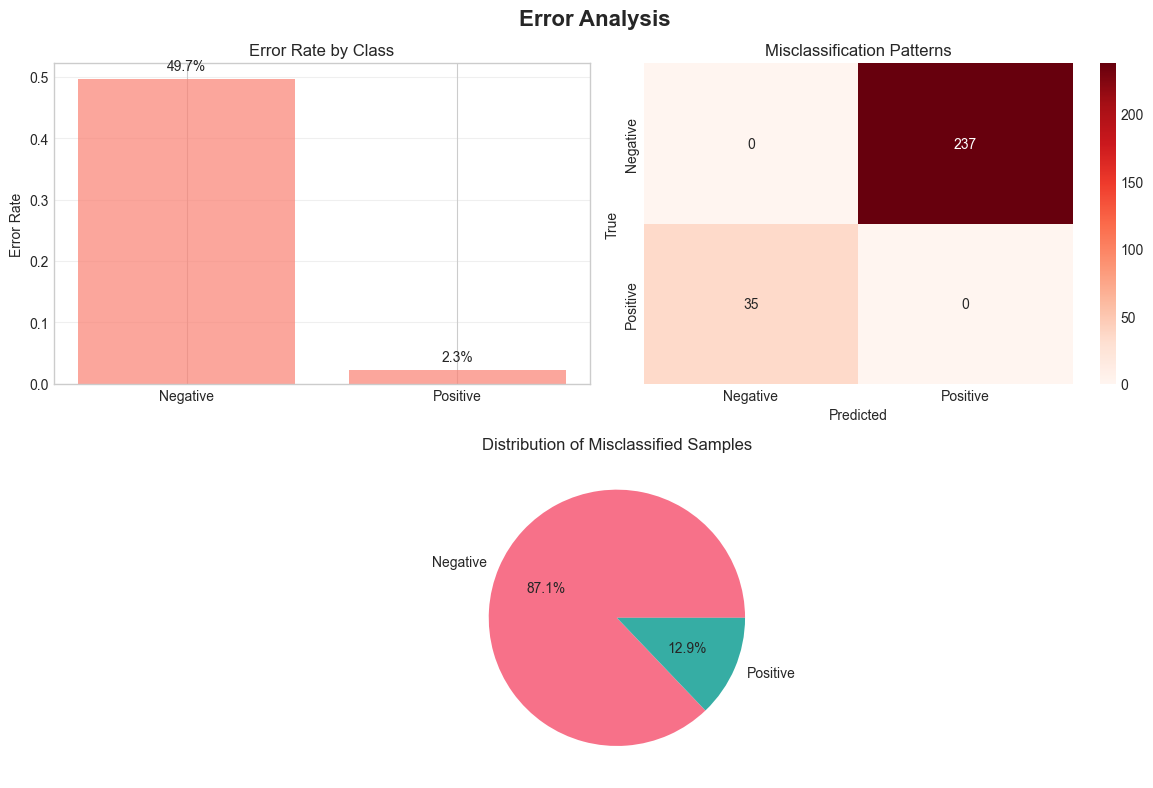

Total Errors: 272 out of 2000 (13.6%)


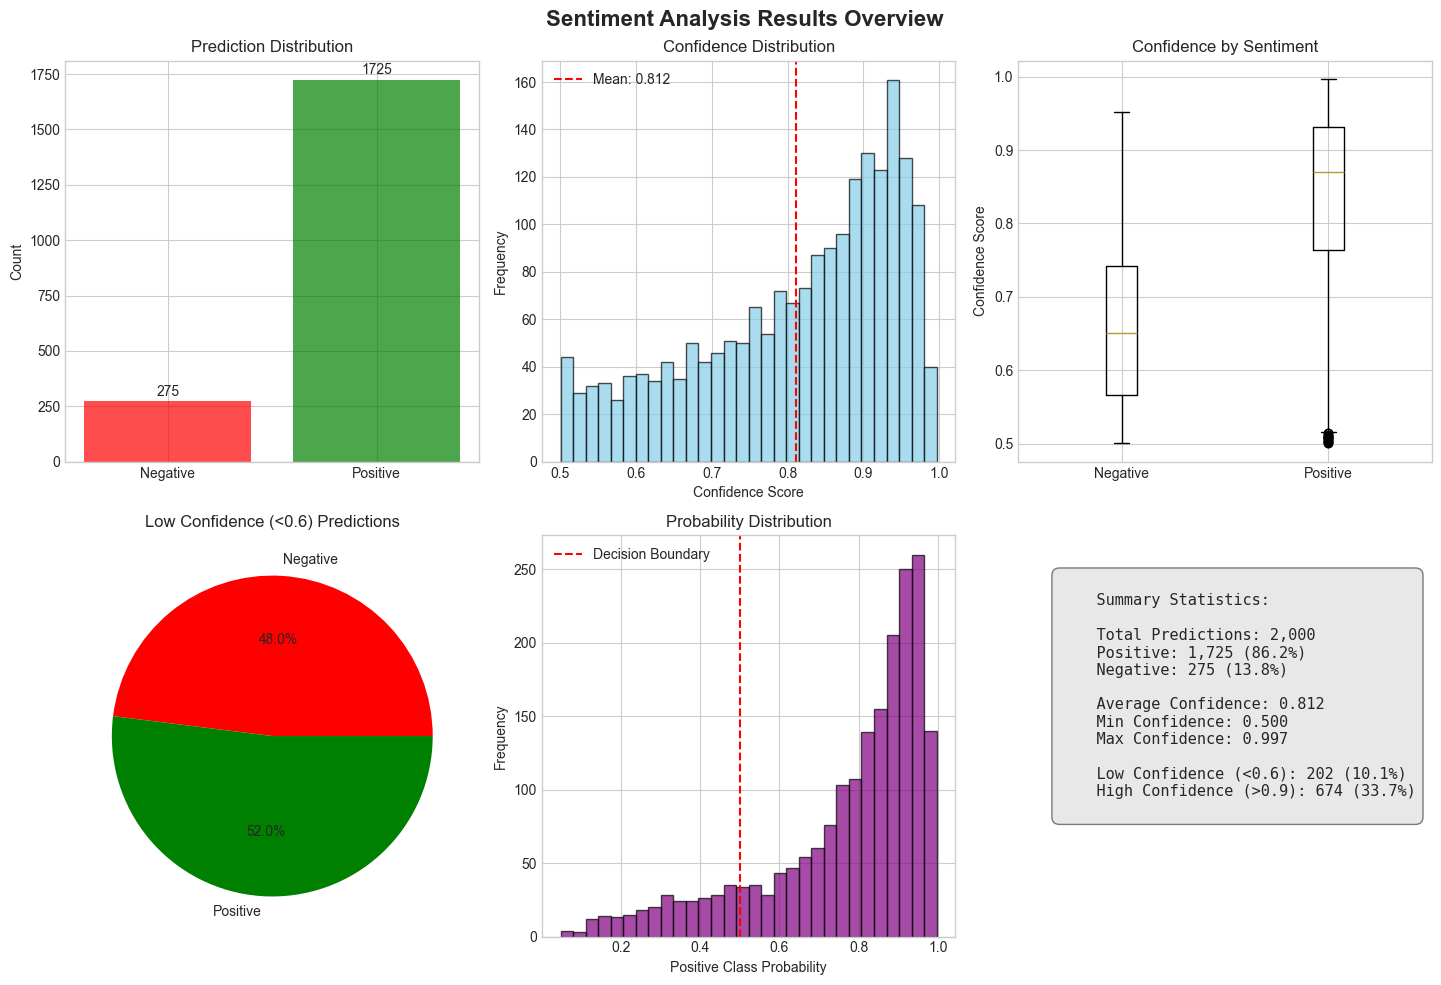

In [7]:
# Example 1: Confusion Matrix
cm = plot_confusion_matrix(y_test, y_pred, 
                          class_names=['Negative', 'Positive'],
                          normalize=True,
                          title='Logistic Regression - Confusion Matrix')

# Example 2: ROC Curve
plot_roc_curve(y_test, y_proba, 
               class_names=['Negative', 'Positive'],
               title='ROC Curve - Logistic Regression')

# Example 3: Class Distribution
plot_class_distribution(y_train, 
                       class_names=['Negative', 'Positive'],
                       title='Training Data Distribution')

# Example 4: Error Analysis
plot_error_analysis(y_test, y_pred, 
                   class_names=['Negative', 'Positive'])

# Example 5: Sentiment Results Overview
plot_sentiment_results(y_pred, y_proba, 
                      title='Sentiment Analysis Results Overview')